In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# adding compuation tools
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sts

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
# create engine t/o hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

# Assign the measurement class to a variable called `Measurement`
# Assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session
session = Session(engine)

In [3]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23')]

In [4]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# assigning variables for last 12 months in date time
most_recent_dt = dt.datetime(2017, 8, 23)
year_ago = most_recent_dt - dt.timedelta(days=365)

# pulling last 12 months of prcp data in session query 
prcp_q = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()

In [5]:
# assigning query into a dataframe
prcp_df = pd.DataFrame(prcp_q)

# setting df index to the date variable
ind_prcp_df = prcp_df.set_index("date")

# filling n/a rows with 0 values
fill_na_prcp_df = ind_prcp_df.fillna(0)

# alternative approcah to drop n/a rows
drop_na_prcp_df = ind_prcp_df.dropna()

# playing around with to_datetime() function. did not have sucess here.
# dt_prcp_df = prcp_df.to_datetime()

In [6]:
# assigning columns to lists for plotting
date = fill_na_prcp_df.index
prcp = fill_na_prcp_df["prcp"]


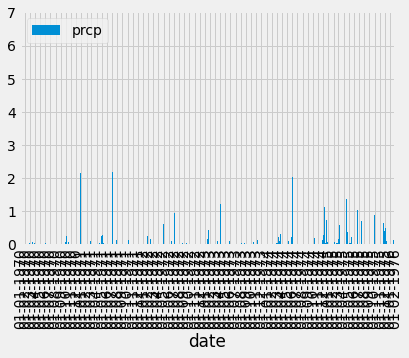

In [7]:
# had issues assinging a variable for month axis
ax = fill_na_prcp_df.plot.bar()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.show()

In [8]:
#summary stats
#
avg_prcp = round(np.mean(prcp),6)
median_prcp = np.median(prcp)
mode_prcp = sts.mode(prcp)
var_prcp = round(np.var(prcp),6)
sd_prcp = round(np.std(prcp),6)

print(f'Average precipitation {avg_prcp} inches')
print(f'Median precipitation {median_prcp} inches')
print(f'Mode precipitation {mode_prcp[0][0]} inches')
print(f'Variance precipitation {var_prcp} inches')
print(f'Standard Deviation precipitation {sd_prcp} inches')

print('*Note summary stats including n/a rows as 0 values')


Average precipitation 0.159951 inches
Median precipitation 0.01 inches
Mode precipitation 0.0 inches
Variance precipitation 0.194587 inches
Standard Deviation precipitation 0.441121 inches
*Note summary stats including n/a rows as 0 values


In [9]:
# additional inspection done here and used in above and below cells
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# station query
station_q = session.query(Station.id,Station.station,Station.name).all()
station_q

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'USC00517948', 'PEARL CITY, HI US'),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [13]:
#number of stations
num_stations = len(station_q)
print(f'There are {num_stations} total Stations')

There are 9 total Stations


In [14]:
#joining dataframes to find the most prevelant station in the data set
join_station = session.query(Measurement, Station).filter(Measurement.station == Station.station).all()

station_list = []
station_name_list = []
for record in join_station:
    (measurment, station) = record
    station_list.append(measurment.station)
    station_name_list.append(station.name)

# creaing dataframes from above lists
station_df = pd.DataFrame(station_list)
station_name_df = pd.DataFrame(station_name_list)

# checking the len of the lists for merging
print(len(station_df))
print(len(station_name_df))

#most prevalent stations name in the data set
station_name_df.value_counts()


19550
19550


WAIHEE 837.5, HI US                       2772
WAIKIKI 717.2, HI US                      2724
KANEOHE 838.1, HI US                      2709
WAIMANALO EXPERIMENTAL FARM, HI US        2669
MANOA LYON ARBO 785.2, HI US              2612
KUALOA RANCH HEADQUARTERS 886.9, HI US    2202
HONOLULU OBSERVATORY 702.2, HI US         1979
PEARL CITY, HI US                         1372
UPPER WAHIAWA 874.3, HI US                 511
dtype: int64

In [15]:
#most prevalent station id in the data set
station_df.value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
dtype: int64

In [16]:
#Using the most active station id, calculate the lowest, highest, and average temperature.
#Hint: You will need to use a function such as func.min, func.max, func.avg, and func.count in your queries.

#USC00519281

# session query on the observation temps
temp_q = session.query(Measurement.tobs,Measurement.station).filter(Measurement.station == 'USC00519281').all()

# creating dataframe
temp_df = pd.DataFrame(temp_q)

# assining variable for temperature column
avg_temp = temp_df["tobs"]


In [17]:
#Using the most active station id, calculate the lowest, highest, and average temperature.

min_temp = min(avg_temp)
max_temp = max(avg_temp)
avg_avg_temp = round(np.mean(avg_temp),3)

print(f'Max Avg Temp Observed at WAIHEE 837.5 was {max_temp}F')
print(f'Min Avg Temp Observed at WAIHEE 837.5 was {min_temp}F')
print(f'Average Avg Temp Observed at WAIHEE 837.5 was {avg_avg_temp}F')

Max Avg Temp Observed at WAIHEE 837.5 was 85.0F
Min Avg Temp Observed at WAIHEE 837.5 was 54.0F
Average Avg Temp Observed at WAIHEE 837.5 was 71.664F


In [18]:
last_obdate_waihee = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).limit(1).all()

last_obdate_waihee

[('2017-08-18')]

In [19]:
most_recent_waihee_dt = dt.datetime(2017, 8, 18)
year_ago_waihee = most_recent_waihee_dt - dt.timedelta(days=365)
year_ago_waihee

datetime.datetime(2016, 8, 18, 0, 0)

In [20]:
# querying the temp observations for the station with the obs over the past year
tobs_waihee_q = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago_waihee).\
    filter(Measurement.station == 'USC00519281').all()

tobs_waihee_df = pd.DataFrame(tobs_waihee_q)
tobs_waihee_df

,tobs
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0
...,...
351,77.0
352,77.0
353,76.0
354,76.0


<AxesSubplot:ylabel='Frequency'>

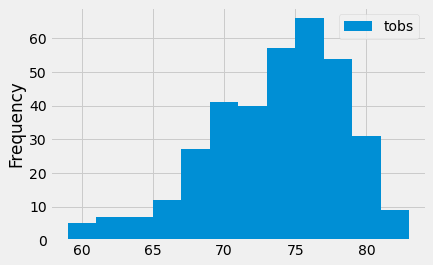

In [21]:
tobs_waihee_df.plot.hist(rot=0,xlabel="Temperature",bins=12)

<AxesSubplot:xlabel='Temp F bins', ylabel='Frequency'>

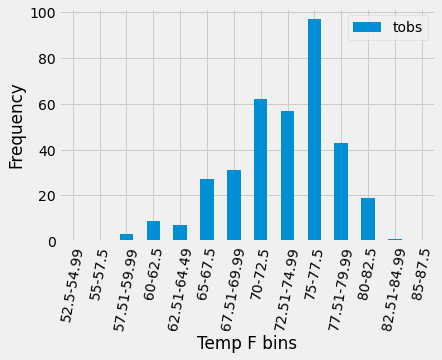

In [22]:

# didn't reallize histograms could assign binning, so trying manually binning and making a bar graph
bins = [52.5, 54.99, 57.5, 59.99, 62.5, 64.99, 67.5, 69.99,72.5, 74.99, 77.5, 79.99, 82.5,84.99, 87.5]
labels = ["52.5-54.99","55-57.5","57.51-59.99","60-62.5","62.51-64.49","65-67.5","67.51-69.99","70-72.5","72.51-74.99","75-77.5","77.51-79.99","80-82.5","82.51-84.99","85-87.5"]

tobs_waihee_df["tobs_bins"] = pd.cut(tobs_waihee_df["tobs"], bins, labels=labels, include_lowest=True)

tobs_bins_group = tobs_waihee_df.groupby(["tobs_bins"])

bins_count_df = pd.DataFrame(tobs_bins_group.count())

bins_count_df.plot.bar(rot=80,ylabel="Frequency",xlabel="Temp F bins")

In [23]:
# closing out the session
session.close_all

<bound method _SessionClassMethods.close_all of <class 'sqlalchemy.orm.session.Session'>>